# Read Sentinel-2 data from remote location

In [1]:
from pystac.extensions.eo import EOExtension as eo
import pystac_client
import planetary_computer
from rich.console import Console
console = Console()

catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

In [2]:
time_range = "2023-09-01/2023-09-21"

# GEOJSON can be created on geojson.io
area_of_interest = {
  "coordinates": [
          [
            [
              14.631570827879642,
              48.95580055524857
            ],
            [
              14.631570827879642,
              48.495695436823524
            ],
            [
              15.727627794927486,
              48.495695436823524
            ],
            [
              15.727627794927486,
              48.95580055524857
            ],
            [
              14.631570827879642,
              48.95580055524857
            ]
          ]
        ],
        "type": "Polygon"
}

In [3]:
search = catalog.search(
    collections=["sentinel-2-l2a"],
    intersects=area_of_interest,
    datetime=time_range,
    query={"eo:cloud_cover": {"lt": 10},
           "s2:nodata_pixel_percentage": {"lt": 20}},
)

# Check how many items were returned
items = search.item_collection()
console.print(f"Returned {len(items)} Items")

Returned 14 Items

In [4]:
least_cloudy_item = min(items, key=lambda item: eo.ext(item).cloud_cover)

console.print(
    f"Choosing {least_cloudy_item.id} from {least_cloudy_item.datetime.date()}"
    f" with {eo.ext(least_cloudy_item).cloud_cover}% cloud cover"
)

Choosing S2A_MSIL2A_20230907T100031_R122_T33UWQ_20230907T211348 from 2023-09-07 with 0.000488% cloud cover

In [5]:
asset_href = least_cloudy_item.assets["visual"].href

In [6]:
asset_href = items[10].assets["visual"].href

In [7]:
import rasterio
from rasterio import windows,features, warp, crs

import numpy as np
from PIL import Image

with rasterio.open(asset_href) as ds:
    aoi_bounds = features.bounds(area_of_interest)
    warped_aoi_bounds = warp.transform_bounds(crs.CRS.from_epsg(4326), ds.crs, *aoi_bounds)
    aoi_window = windows.from_bounds(transform=ds.transform, *warped_aoi_bounds)
    band_data = ds.read(window=aoi_window)

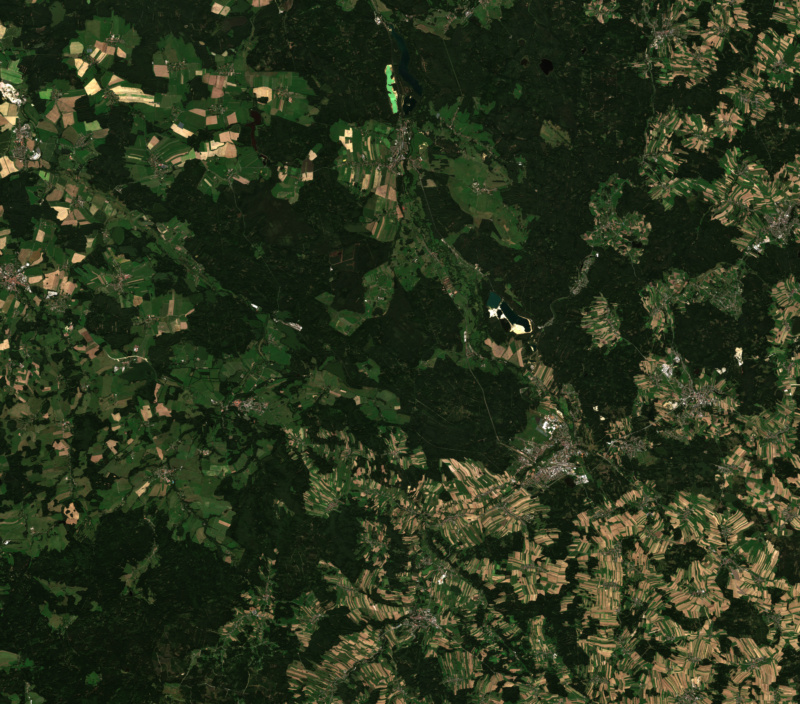

In [8]:
img = Image.fromarray(np.transpose(band_data, axes=[1, 2, 0]))
w = img.size[0]
h = img.size[1]
aspect = w / h
target_w = 800
target_h = (int)(target_w / aspect)
img.resize((target_w, target_h), Image.Resampling.BILINEAR)